In [1]:
import sys
sys.path.append("..")

import networkx as nx
import matplotlib.pyplot as plt
from src.graphgen.synthetic_graph_dataset import *
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [2]:
dataset = SyntheticGraphDataset('graphGenDataset100.pkl')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')
print(f'Class label: ', data.y)
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges/2}') # divide by 2 because of undirected edges
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: SyntheticGraphDataset(100):
Number of graphs: 100
Number of features: 10

Data(x=[85, 10], edge_index=[2, 2166], y=[1])
Class label:  tensor([0])
Number of nodes: 85
Number of edges: 1083.0
Average node degree: 25.48
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/Users/kumarh/Documents/fall_co-op_2023/experiments/../src/graphgen/synthetic_graph_dataset.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/torch/csrc/utils/tensor_new.cpp:233.)
  edge_index = torch.tensor(graph_adj.nonzero(), dtype=torch.long)


nodes: 85
edges: 1083
label: 0


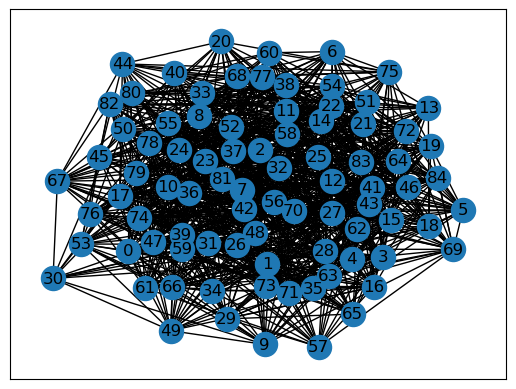

In [5]:
## verify the dataset

with open('graphGenDataset100.pkl', 'rb') as f:
    dataset = pickle.load(f)

gg = nx.Graph(dataset[0][0])
nx.draw_networkx(gg, pos=nx.spring_layout(gg))

print(f'nodes: {len(gg.nodes())}')
print(f'edges: {len(gg.edges())}')
print(f'label: {dataset[0][3]}')


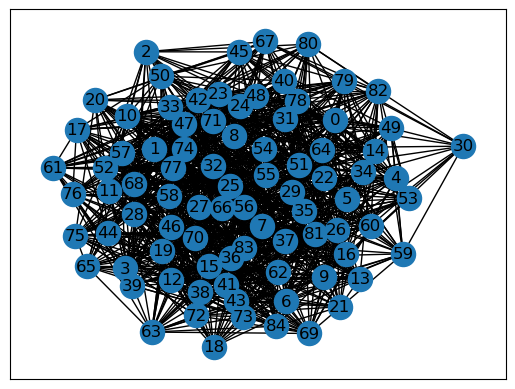

In [3]:
# Convert the PyTorch Geometric Data object to a NetworkX graph
graph = nx.Graph()
graph.add_nodes_from(range(data.num_nodes))
graph.add_edges_from(data.edge_index.t().tolist())

# Visualize the graph
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, pos=pos)
plt.show()

In [4]:
# Split the dataset into training and testing subsets (you can use other methods for splitting)
train_dataset = dataset[:int(0.8 * len(dataset))]
test_dataset = dataset[int(0.8 * len(dataset)):]

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# Define a Graph Convolutional Network (GCN) model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate the GCN model
model = GCN(num_features=dataset.num_node_features, num_classes=2)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
def train(model, train_loader, optimizer, criterion):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

# Test the model
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            _, predicted = torch.max(out, 1)
            total += batch.y.size(0)
            correct += (predicted == batch.y).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Training
for epoch in range(100):
    train(model, train_loader, optimizer, criterion)
    accuracy = test(model, test_loader)
    print(f'Epoch {epoch + 1}, Accuracy: {accuracy:.2f}%')


ValueError: Expected input batch_size (5440) to match target batch_size (64).